This notebook assumes you have sims_maf version >= 1.1 and have 'setup sims_maf' in your shell. 

#Transient metric#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

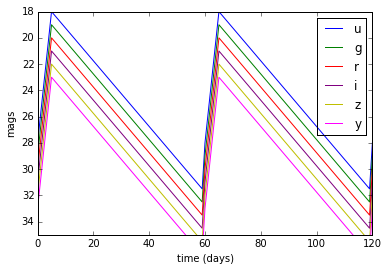

In [2]:
# Let's look at how the transient metric makes light curves
peaks = {'uPeak':18, 'gPeak':19, 'rPeak':20, 'iPeak':21, 'zPeak':22,'yPeak':23}
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 60. # Days
transMetric = metrics.TransientMetric(riseSlope=-2., declineSlope=0.25, 
                                      transDuration=transDuration, peakTime=5., **peaks)


times = np.arange(0.,121,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

So the transient metric basically takes a simple lightcurve, repeats it continually over the entire survey length, and then checks to see what fraction of the lightcurves meet some specified criteria.

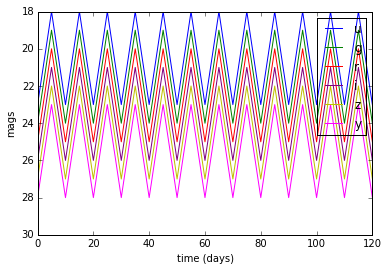

In [3]:
# Modify the slopes and duration a bit
transDuration = 10.
transMetric = metrics.TransientMetric(riseSlope=-1., declineSlope=1, transDuration=transDuration, 
                                 peakTime=5., **peaks)


times = np.arange(0.,121,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([30,18])
plt.legend()

By default, the transient metric let's you make simple saw-tooth light curves.  If you want to use a more complicated light curve, one can simply sub-class the transient metric and replace the lightCurve method with a function of your own. 

In [4]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of 60-day, r=20 mag flat transients are detected at least once?
metric = metrics.TransientMetric(riseSlope=0., declineSlope=0., transDuration=60., 
                                 peakTime=5., rPeak=20., metricName='Alert')
metricList.append(metric)
# Now make the light curve shape a little more realistic. 
metric = metrics.TransientMetric(riseSlope=-2., declineSlope=0.25, transDuration=60., 
                                 peakTime=5., rPeak=20., metricName='Alert, shaped LC')
metricList.append(metric)
#  Demand 2 points before tmax before counting the LC as detected
metric = metrics.TransientMetric(riseSlope=-2., declineSlope=0.25, transDuration=60., 
                                 peakTime=5., rPeak=20., nPrePeak=2, metricName='Detected on rise')
metricList.append(metric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'filter = "r"'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

In [6]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

In [8]:
bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint filter = "r"
Found 544710 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression 'filter = "r"' should be explicitly declared as text('filter = "r"') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


Plotting.
monopole: 0.400104  dipole: lon: 89.8754, lat: -68.2802, amp: 0.134947
monopole: 0.250889  dipole: lon: 98.071, lat: -63.0287, amp: 0.0922803
monopole: 0.0332542  dipole: lon: 113.641, lat: -58.0792, amp: 0.0167816
Plotting complete.


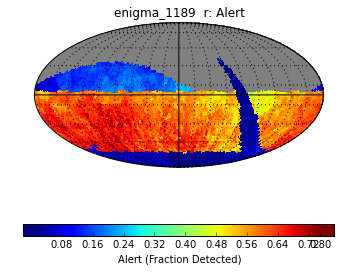

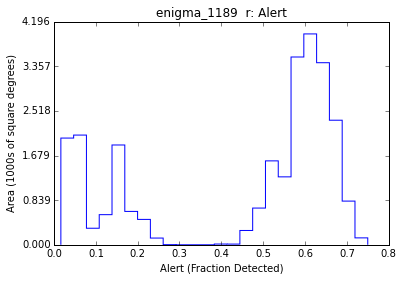

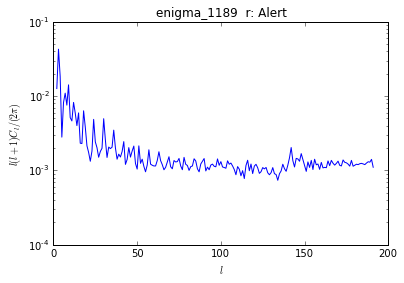

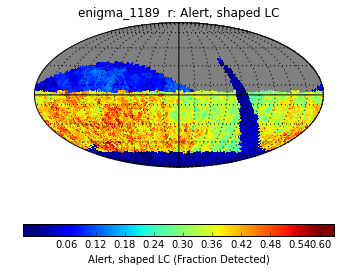

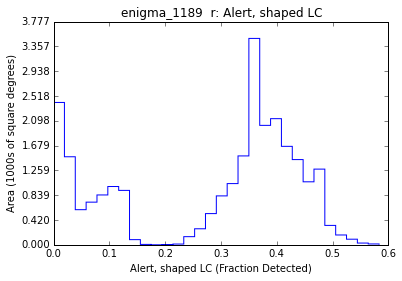

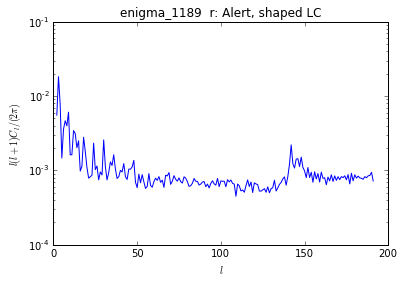

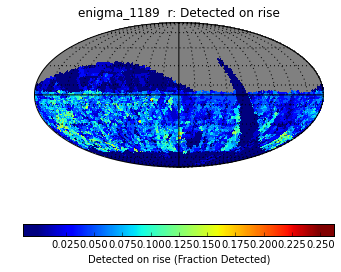

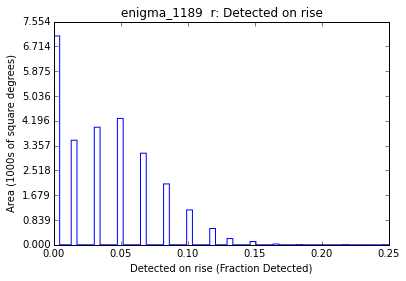

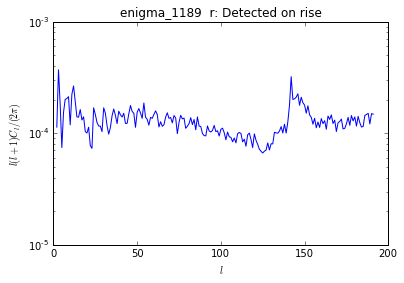

In [9]:
bgroup.plotAll(closefigs=False)

In [10]:
# Compute and print summary metrics
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

Alert {'Median': 0.56666666666666665}
Alert, shaped LC {'Median': 0.34999999999999998}
Detected on rise {'Median': 0.033333333333333333}


Querying database with constraint 
Found 2469307 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.543445  dipole: lon: 87.9137, lat: -70.5385, amp: 0.125453
monopole: 0.410113  dipole: lon: 86.4566, lat: -65.6147, amp: 0.1232
monopole: 0.113052  dipole: lon: -144.12, lat: -82.2946, amp: 0.0284787
Plotting complete.
Alert {'Median': 0.76666666666666672}
Alert, shaped LC {'Median': 0.56666666666666665}
Detected on rise {'Median': 0.13333333333333333}


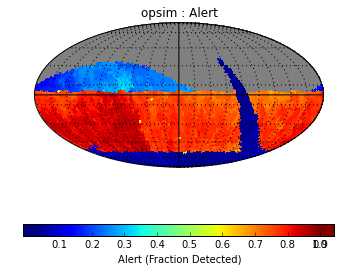

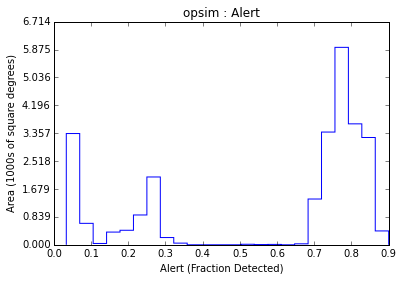

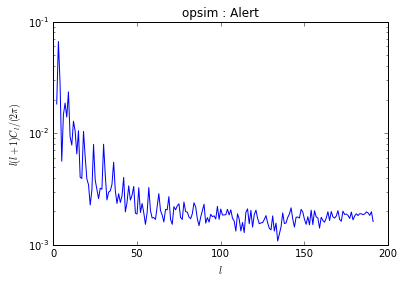

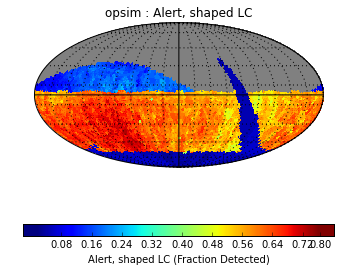

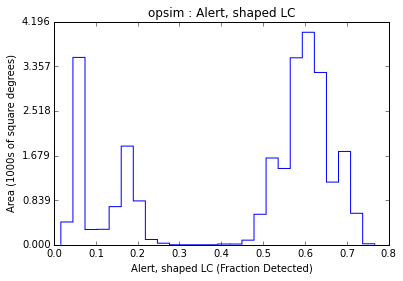

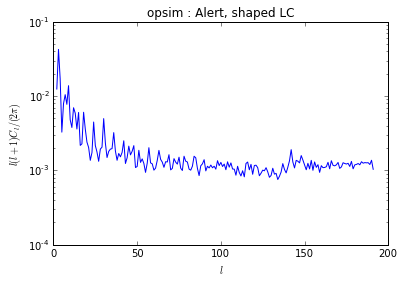

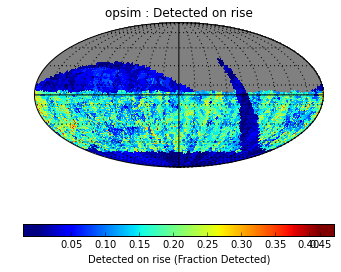

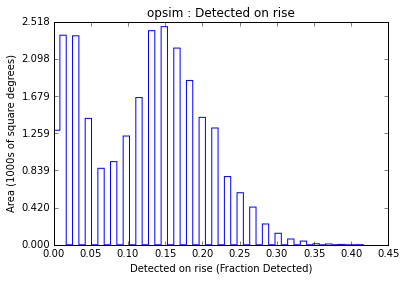

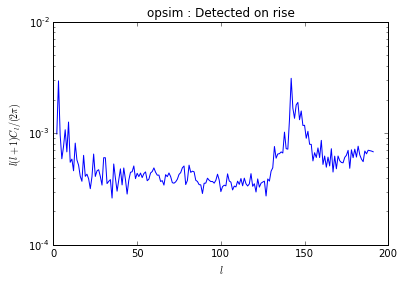

In [11]:
# Update to use all the observations, not just the r-band
bDict={}
sqlconstraint = ''
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, summaryMetrics=summaryMetrics)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

In [12]:
bDict[0].metricValues

masked_array(data = [-- -- -- ..., 0.05 0.05 0.06666666666666667],
             mask = [ True  True  True ..., False False False],
       fill_value = -1.6375e+30)